In [1]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM_ import RTRBM as RTRBM_
from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RTRBM_no_bias import RTRBM_nobias
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

"\nto dump:\n\npath = os.path.dirname(os.getcwd())\npickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))\n\nto load:\n\n\ncheck1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))\n"

How many batches are nessesary to reproduce the weights with a pearson correlation of > 0.95


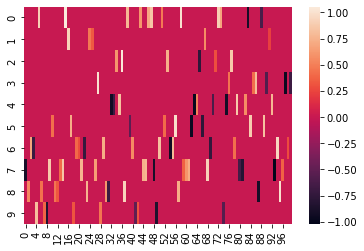

<AxesSubplot:>

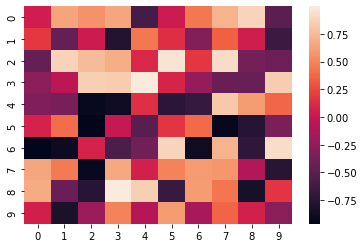

In [94]:
N_H = 10
N_V = 100
T = 30

n_batches = 200
nabla = 0.1
sp = 0.9
min = -1
max = 1

W = nabla * torch.randn((N_H, N_V), dtype=torch.float)
temp_W = (min - max) * torch.rand(N_H, dtype=torch.float) + max
W += np.random.choice(np.array(temp_W), size=(N_H, N_V))

for i in range(N_V):
    if torch.sum(W[:, i]==0)/N_H<sp:
        W[:, i][ np.random.permutation(N_H)[:int(np.ceil(sp * N_H))]] = 0
# if torch.sum(W==0)/W.numel()<sp:
#     W.ravel()[ np.random.permutation(W.numel())[:int(np.ceil(sp * W.numel()))]] = 0

W_acc = (min - max) * torch.rand((N_H, N_H), dtype=torch.float) + max
b_init = torch.zeros(1, N_H, dtype=torch.float)
b_V = -1 * torch.ones(1, N_V, dtype=torch.float)
b_H = torch.zeros(1, N_H, dtype=torch.float)

data = torch.zeros(N_V, T, dtype=torch.float)

rtrbm = RTRBM(data, N_H=N_H, device='cpu')
rtrbm.W = W
rtrbm.W_acc = W_acc
rtrbm.b_init = b_init
rtrbm.b_V = b_V
rtrbm.b_H = b_H

sns.heatmap(W)
plt.show()
sns.heatmap(W_acc)

<AxesSubplot:>

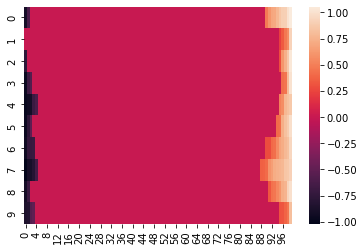

In [95]:
W1 = torch.zeros_like(W)
for i in range(W.shape[0]):
    W1[i, :] = W[i, torch.argsort(W[i, :], descending=False)]

sns.heatmap(W1)

tensor(0.3241)


C:\Users\sebas\AppData\Local\Temp/ipykernel_12424/481334599.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float, device='cpu')


<AxesSubplot:>

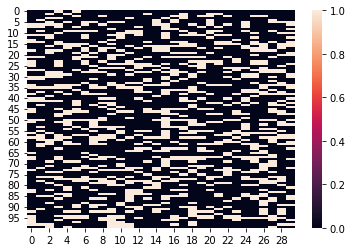

In [96]:
data = torch.zeros(N_V, T, n_batches)
rt = torch.zeros(N_H, T, n_batches)
for batch in range(n_batches):
    v_start = (torch.rand(N_V) > 0.3)*1.0
    data[:, :, batch], rt[:, :, batch] = rtrbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)
data = torch.tensor(data, dtype=torch.float, device='cpu')
print(torch.mean(data))
sns.heatmap(data[:, :, 0].cpu())

100%|██████████| 300/300 [06:59<00:00,  1.40s/it]


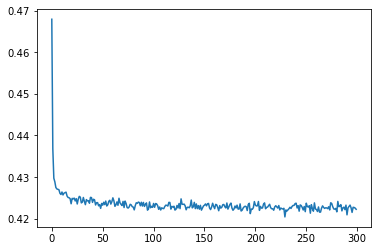

In [97]:
rtrbm_ = RTRBM_nobias(data, N_H=N_H, device='cpu')
rtrbm_.learn(n_epochs=300, batchsize=1, CDk=10, lr=1e-4, mom=0.9, wc=0.0002, sp=3e-6, x=2)
plt.plot(rtrbm_.errors)

In [2]:
def init_rtrbm_and_sample(N_V, N_H, T, n_batches):
    # Initialize original RTRBM

    min = -1
    max = 1

    W = (min - max) * torch.rand((N_H, N_V), dtype=torch.float) + max
    W_acc = (min - max) * torch.rand((N_H, N_H), dtype=torch.float) + max
    b_init = torch.zeros(1, N_H, dtype=torch.float)
    b_V = torch.zeros(1, N_V, dtype=torch.float)
    b_H = torch.zeros(1, N_H, dtype=torch.float)

    data = torch.zeros(N_V, T, dtype=torch.float)

    rtrbm = RTRBM(data, N_H=N_H, device='cpu')
    rtrbm.W = W
    rtrbm.W_acc = W_acc
    rtrbm.b_init = b_init
    rtrbm.b_V = b_V
    rtrbm.b_H = b_H
    
    data = torch.zeros(N_V, T, n_batches)
    rt = torch.zeros(N_H, T, n_batches)
    for batch in range(n_batches):
        v_start = (torch.rand(N_V) > 0.2)*1.0
        data[:, :, batch], rt[:, :, batch] = rtrbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)
        
    return data, rtrbm

In [3]:
N_V = 1000
T = 30
N_H = 5

max_epoch = 1000
n_rtrbms = 1
rtrbm_list_batchsize = []
rtrbm_original_list_batchsize = []

for batchsize in tqdm(500):
    print(batchsize)
    rtrbm_list = []
    rtrbm_original_list = []
    
    for _ in range(n_rtrbms):
        
        data, rtrbm = init_rtrbm_and_sample(N_V=N_V, N_H=N_H, T=T, n_batches=batchsize)
        
        rtrbm_ = RTRBM_(data, N_H=N_H, device='cuda')
        rtrbm_.learn(max_epochs=100, batchsize=1, CDk=10, lr=1e-4, mom=0.9, wc=0.0002, sp=3e-6, x=2)
        
        rtrbm_list.append(rtrbm_)
        rtrbm_original_list.append(rtrbm)
        
    rtrbm_list_batchsize.append(rtrbm_list) 
    rtrbm_original_list_batchsize.append(rtrbm_original_list)   
        
    
# Calculate Pearson correlation of the trained weights



  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

500


  0%|                                                                                            | 0/8 [08:42<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
n_batches = len(rtrbm_original_list_batchsize)
n_rtrbms = len(rtrbm_original_list_batchsize[0])
r_VH = torch.zeros([n_batches, n_rtrbms])
r_HH = torch.zeros([n_batches, n_rtrbms])

for batch in tqdm(range(n_batches)):
    for m in range(n_rtrbms):
        W_original = rtrbm_original_list_batchsize[batch][m].VH.detach().clone()
        W_train = rtrbm_list_batchsize[batch][m].VH.detach().clone()
        W_acc_original = rtrbm_original_list_batchsize[batch][m].HH.detach().clone()
        W_acc_train = rtrbm_original_list_batchsize[batch][m].HH.detach().clone()

        corr = np.zeros((N_H, N_H))
        shuffle_idx = np.zeros((N_H))
        for i in range(N_H):
            for j in range(N_H):
                corr[i, j] = np.correlate(W_original[i,:], W_train[j,:])
            shuffle_idx[i] = np.argmax(corr[i,:])

        W_train = W_train[shuffle_idx, :]    
        W_acc_train = W_acc_train[shuffle_idx, :]
        W_acc_train = W_acc_train[:, shuffle_idx]

        _, _, r_VH[batch, m], _, _ = linregress(W_original.ravel(), W_train.ravel())
        _, _, r_HH[batch, m], _, _ = linregress(W_acc_original.ravel(), W_acc_train.ravel())
        
print(r_VH, r_HH)